### Finding the CE parameters used 

In [1]:
from clease.tools import reconfigure
from clease import  NewStructures,Evaluate
from clease.settings import Concentration, CECrystal, CEBulk
from clease.tools import reconfigure
from clease.regression import PhysicalRidge,LinearRegression
from clease.basis_function import BinaryLinear
from clease.regression.physical_ridge import random_cv_hyper_opt
from clease.settings import settings_from_json

import logging
logging.basicConfig(level=logging.INFO)
from clease.corr_func import CorrFunction
import clease.plot_post_process as pp

from pathlib import Path
import toml, os
import numpy as np

# Setup the paths
run_path = Path('.') # path to were you want the result to be stored

CE_model_path= str(run_path/'CE_model_new')
cfg_path = CE_model_path+'/config.toml' # path to new config file, which will contain all params
run_path = CE_model_path

# Load the CE model parameters
with open(cfg_path, 'r') as f:
    CE_model_dict = toml.load(f)['CE']

# Define iteration number, which you know is manuelly set in the config file
iter_idx = 9999

# print your CE model parameters
print(CE_model_dict)

{'auto_set_cell': False, 'space_group': 62, 'basis_index': [[0], [1], [2], [3, 4, 5]], 'basis_coord': [[0, 0, 0], [0.28619, 0.25, 0.985605], [0.108, 0.25, 0.441755], [0.11328, 0.25, 0.749385], [0.46909, 0.25, 0.160365], [0.17764, 0.05403, 0.313465]], 'basis_element': [['Na', 'X'], ['Fe', 'Mn'], ['P'], ['O'], ['O'], ['O']], 'A_eq': [['1', '1', '0', '0', '0', '0'], ['0', '0', '1', '1', '0', '0'], ['0', '0', '0', '0', '1', '0'], ['0', '0', '0', '0', '0', '1']], 'b_eq': ['1', '1', '1', '1'], 'supercell_factor': 7, 'basis_func_type': 'polynomial', 'max_cluster_dia': [5.0, 5.0], 'n_random_struc': 200, 'scoring_scheme': 'loocv', 'max_cluster_size': 4, 'fitting_scheme': 'l2', 'alpha_min': 1e-07, 'alpha_max': 1000.0, 'num_alpha': 50, 'threshold': 3, 'gs_threshold': 10, 'gs_init_temperature': 1000, 'gs_final_temperature': 300, 'gs_num_temp': 10, 'gs_sweeps': 10000, 'gs_n_random_struc': 20}


### Setting correlation function

In [2]:
# Load initial settings and set the basis function type and size
setting = settings_from_json(run_path+'/initial_setting.json')
basis_func_type = CE_model_dict['basis_func_type'] #: polynomial, trigonometric and binaryLinear.
max_cluster_dia = ['5','5']#CE_model_dict['max_cluster_dia']
setting.basis_func_type=basis_func_type
setting.max_cluster_dia=max_cluster_dia
try: 
    setting.size=CE_model_dict['size']
except:
    setting.supercell_factor = CE_model_dict['supercell_factor']
# Setting the correlation function
cf = CorrFunction(setting)
cf.reconfigure_db_entries(verbose=True)

INFO:clease.corr_func:473 entries will be reconfigured


473 entries will be reconfigured


INFO:clease.corr_func:Reconfiguration complete


Updated 473 of 473 entries. Current ID: 591
reconfiguration completed


### Fitting the CE Model

INFO:clease.db_util:Grabbing metadata with querry SELECT key,value,id FROM clease_metadata
/tmp/ipykernel_302645/3623523838.py:14: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = evl.plot_CV(alpha_min=alpha_min, alpha_max=alpha_max, num_alpha=num_alpha,savefig=True, fname=run_path+f'/alpha_iter{iter_idx}.png')
INFO:clease.evaluate:0.0010000000	 466	 0.0048955968
INFO:clease.evaluate:0.0013894955	 466	 0.0048955901
INFO:clease.evaluate:0.0019306977	 466	 0.0048955807
INFO:clease.evaluate:0.0026826958	 466	 0.0048955676
INFO:clease.evaluate:0.0037275937	 466	 0.0048955494
INFO:clease.evaluate:0.0051794747	 466	 0.0048955242
INFO:clease.evaluate:0.0071968567	 466	 0.0048954891
INFO:clease.evaluate:0.0100000000	 466	 0.0048954404
INFO:clease.evaluate:0.0138949549	 466	 0.0048953727
INFO:clease.evaluate:0.0193069773	 466	 0.0048952787
INFO:clease.evaluate:0.0268269580	 466	 0.0048951483
INFO:clease.evalu

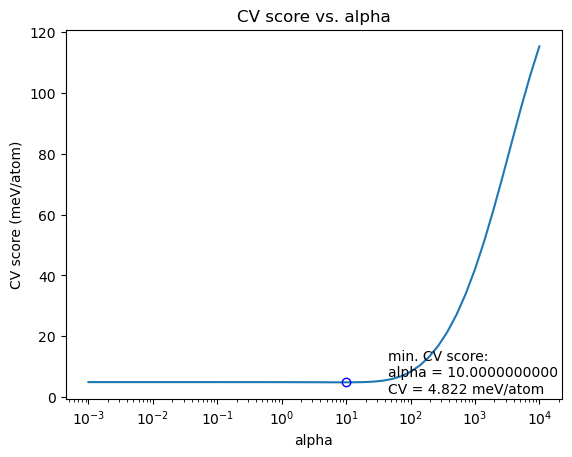

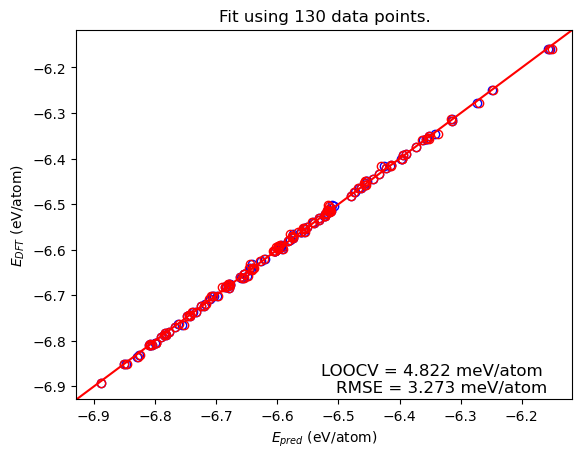

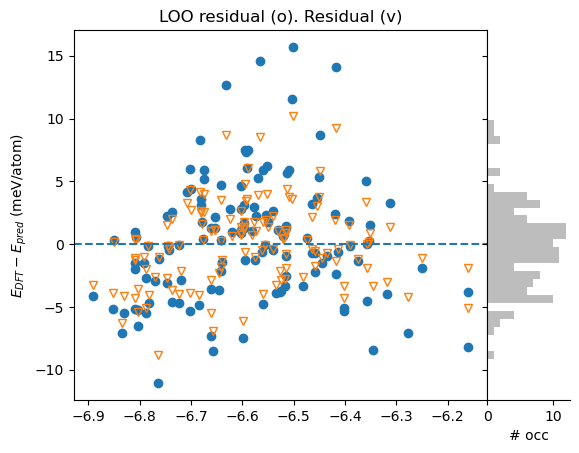

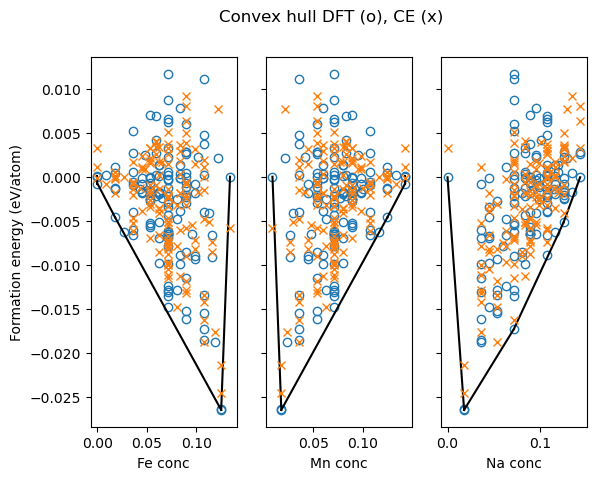

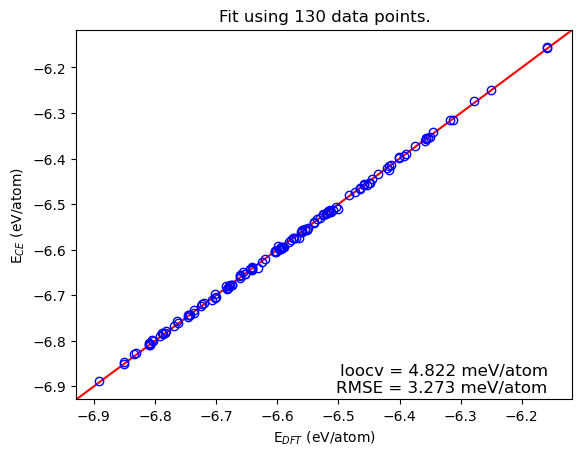

In [4]:
# Set up the evaluation
select_cond = [('converged','=','True')]
scoring_scheme = CE_model_dict['scoring_scheme']
max_cluster_size = 8 # CE_model_dict['max_cluster_size']
evl=Evaluate(setting,select_cond= select_cond, scoring_scheme=scoring_scheme, max_cluster_size=max_cluster_size)

# scan different values of alpha and return the value of alpha that yields
# the lowest CV score
fiting_scheme = 'l2'#CE_model_dict['fitting_scheme']
alpha_min = 1e-3#CE_model_dict['alpha_min']
alpha_max = 1e4 #CE_model_dict['alpha_max']
num_alpha = 50 #CE_model_dict['num_alpha']
evl.set_fitting_scheme(fitting_scheme=fiting_scheme)
alpha = evl.plot_CV(alpha_min=alpha_min, alpha_max=alpha_max, num_alpha=num_alpha,savefig=True, fname=run_path+f'/alpha_iter{iter_idx}.png')

# set the alpha value with the one found above, and fit data using it.
evl.set_fitting_scheme(fitting_scheme=fiting_scheme, alpha=alpha)
evl.fit()  # Run the fit with these settings.
# Plot fit
evl.plot_fit(interactive=False, savefig=True, fname=run_path+f'/fit_new_iter{iter_idx}.png')
fig = pp.plot_fit(evl)#, interactive=True)
fig.savefig(run_path+f'/fit_iter{iter_idx}.png')
# plot ECI values
#fig = pp.plot_eci(evl)
fig.savefig(run_path+f'/eci_iter{iter_idx}.png')

# save a dictionary containing cluster names and their ECIs
evl.save_eci(fname=run_path+f'/eci_iter{iter_idx}.json')


### Looking into the CE fit interactivly

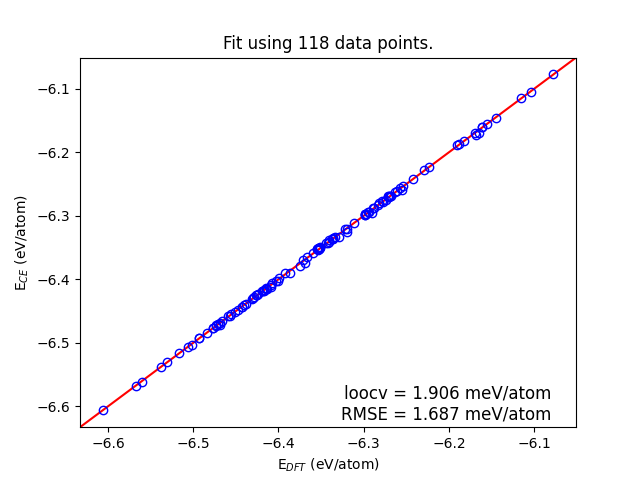

In [6]:
%matplotlib qt
fig = pp.plot_fit(evl,interactive=True)
